<a href="https://colab.research.google.com/github/Ihsan1331/NLP_Course/blob/main/Intro_to_NLP_Ch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Prerequisites
---
link: https://huggingface.co/learn/nlp-course/chapter2/1?fw=pt

#1. Introduction

---
keypoint:
1. 🤗 Transformers package dibuat untuk mempermudah user dalam menggunakan atau melatih model transformer.
2. Chapter ini akan dimulai dengan bagaimana menggunakan mdel dan tokenizer untuk membentuk pipeline() seperti di Ch.1. Kemudian membahas API model, bagaimana meload model dan bagaimana model tersebut berproses hingga mengeluarkan output.


# 2. Behind the pipeline
---
pipeline yang digunakan di Ch. 1 menyatukan 3 proses: preprocessing, model, post processing
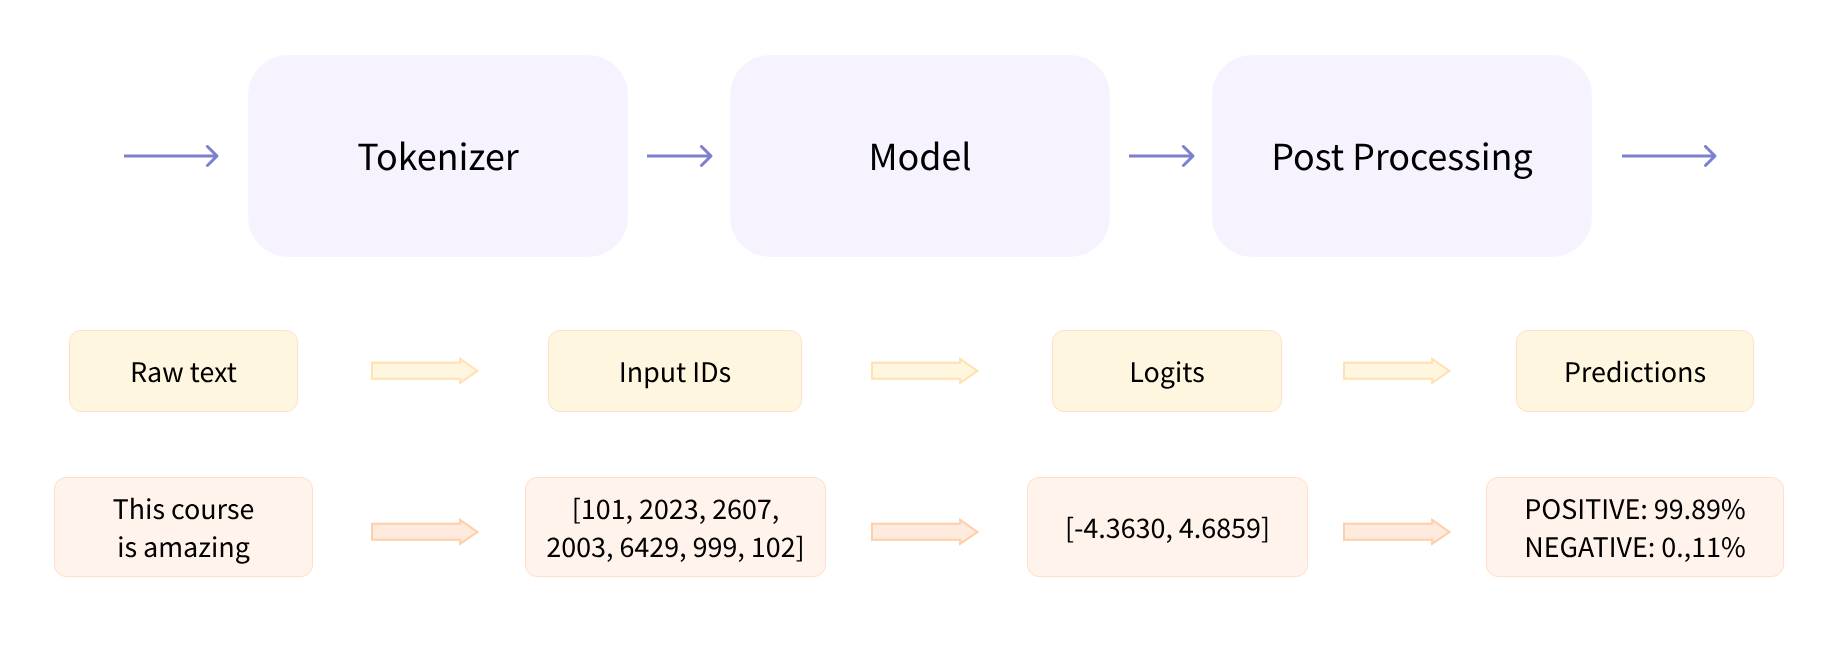

## 2.1 Preprocessing with tokenizer

---
1. sama seperti NN lainnya, transformers tidak bisa menerima teks dalam bentuk raw perlu diubah menjadi vektor.
2. untuk itu akan digunakan fungsi **tokenizer**.
  1. Membagi input menjadi kata, subkata atau simbol yag disebut token
  2. Memetakan tiap token menjadi bilangan bulat
  3. Menambahkan input lain yang berguna untuk model
3. Proses preprocessing harus dilakukan dengan cara yang sama ketika model dipretrained.

In [1]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
# menggunakan from_pretrained dari AutoTokenizer akan mengambil informasi token dari model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [6]:
# contoh kalimat yang akan dimasuk ke dalam model
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]

#tokenizer untuk mengubah kalimat menjadi id dari Token
#return_tensors = buat nentuin tensorsnya mau di return dalma format apa bisa pytorch, TF, numpy, JAX
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


## 2.2 Going thoruch the model

---
1. mirip seperti tokenizer buat download pretrained pake AutoModel

In [7]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

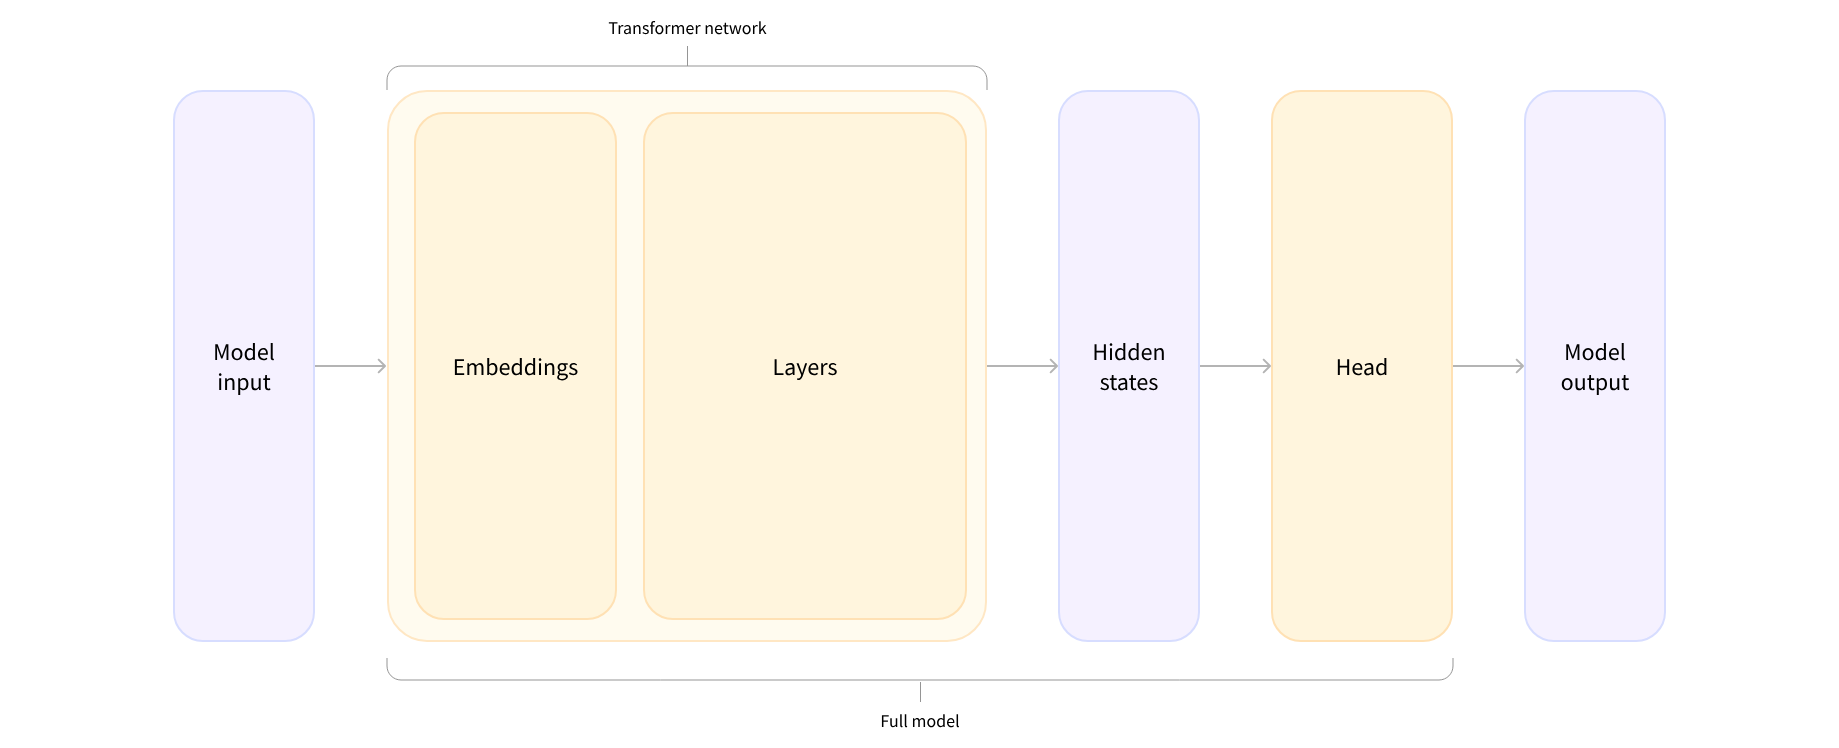
1. Arsitektur yang didownload hanya berisi dasar dari model transformer: dikasih input akan mengeluarkan **hidden states** atau **feature** . untuk setiap input akan megeluarkan vektor berdimensi tinggi yang merepresentasikan konteks pemahaman input oleh si model.
2. **hidden states** akan dihubungkan dengan **head** yang merupakan model lain. Sehingga untuk arsitektur yang sama bisa mengerjakan tugas yang berbeda **karena punya head yang berbeda tergantung tugasnya**.

## 2.3 High Dimensional Vector?

---
1. vektor output dari transformer memiliki 3 dimensi:
  1. batch size: jumlah kalimat yang diproses dalam 1 waktu (dalam contoh ini 2)
  2. sequence length: panjang kalimat (dalam contoh ini 16)
  3. Hidden Size: dimensi vektor dari setiap input (bisa berupa 768, bisa juga 3072 atau lebih tergantung ukuran model)
  

In [9]:
#buat lihat ukuran dari output dari model yang kita pakai
#NB: ini output size dari transformer network
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


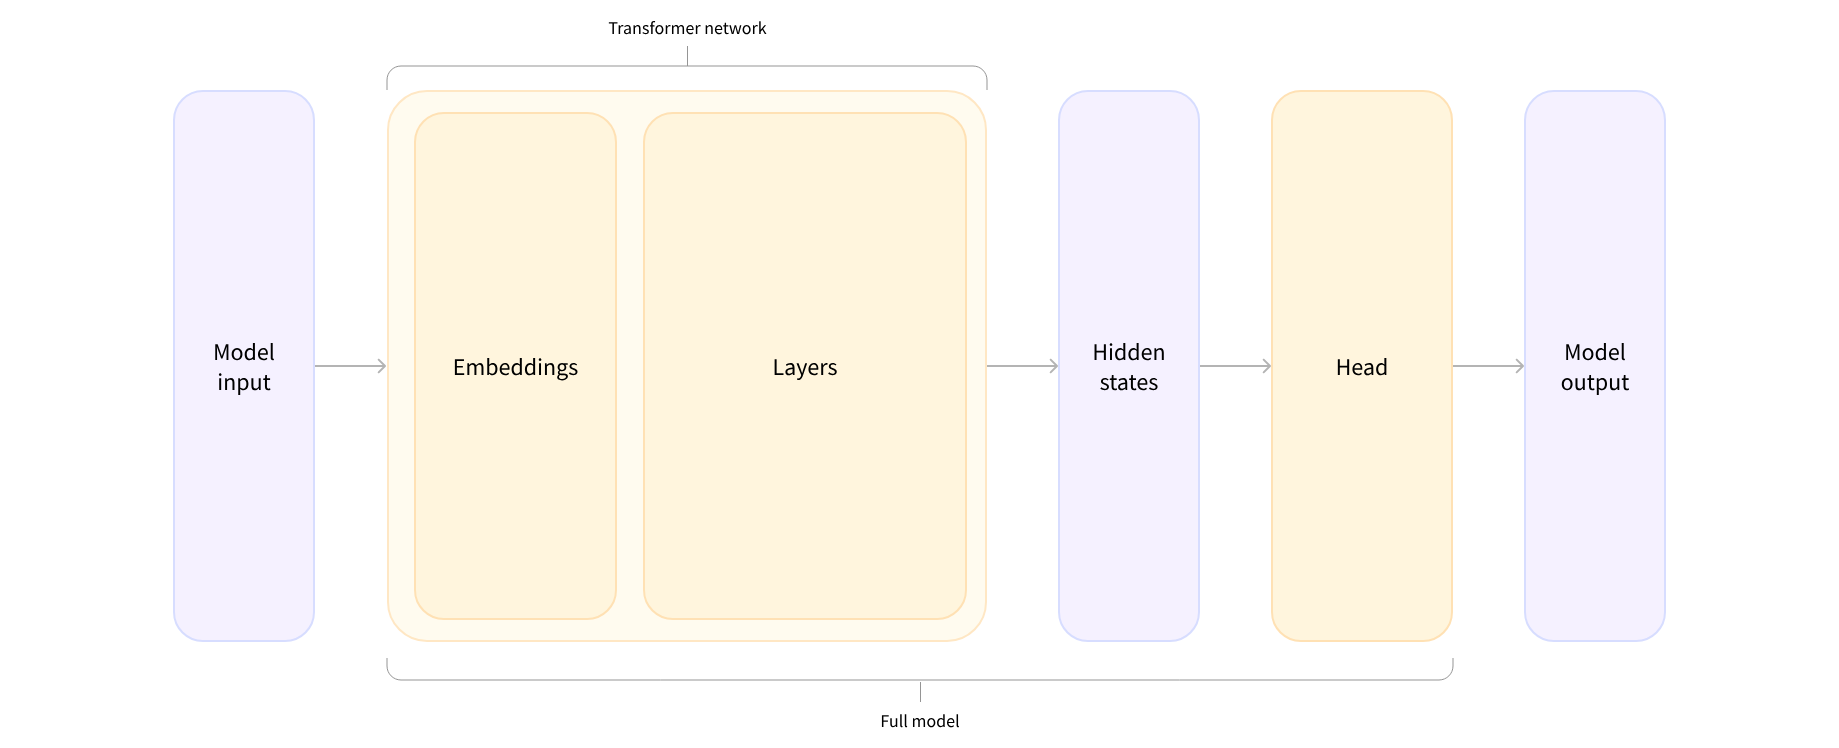

## 2.4 Model Head
---
model head umumnya terdiir dari 1 atau lebih linear layer yanag akan menerima vektor berdimensi tinggi yang merupakan output dari transformers network.

Di 🤗 Transformers ada beberapa arsitektur yang sudah dibuat,

1. Model (output hidden state) (ini yang dipakai barusan)
2. ForCausalLM
3. ForMaskedLM
4. ForMultipleChoice
5. ForQuestionAnswering
6. ForSequenceClassification
7. ForTokenClassification
7. dan lainnya

In [16]:
# karena kita model yang kita pakai default buat sentiment analysis maka kita ganti jadi AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Namun, output yang kita dapatkan masih belum masuk akal oleh karnea itu diperlukan post processing

## 2.5 Postprocessing output

In [18]:
outputs.logits

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


Model memberikan prediksi [-1.5607, 1.6123] untuk kalimat pertama dan [ 4.1692, -3.3464] untuk kalimat kedua. BIlangan ini bukanlah probabilitas tapi logits hasil dari layer terakhir yang masih raw dan tidak dinormalisasi. Untuk diubah ke probabilitas atau peluang menggunakan softmax layer

In [19]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


Terlihat kalau model mengeluarkan 0,0401 ... dan 0.95... untuk kalimat 1. Untuk kalimat 2 0.99... dan 0.0005 yang menandakan kedua kalimat sudah menjadi probabilitas. untuk mendapat labelnya bisa dengan

In [20]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

# 3. Models

In [21]:
# buat BERT model
from transformers import BertConfig, BertModel

# buat konfigurasi dari BERT model
config = BertConfig()

# membuat model BERT dari konfigurasi
model = BertModel(config)

#Model yang dibuat memiliki bobot yang random jadi perlu do train

In [24]:
# buat load model BERT yang sudah dilatih

from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

#kita bisa ganti BertModel jadi AutoModel sama kayak yang udah ditunjukkin sebelumnya

In [25]:
# buat save model
model.save_pretrained("directory")


di folder akan kesimpen 2 file config.json dan model.safatensor
1. config.json buat nyimpen atribuat yang diperlukan untuk bikin arsitektur dan metadata kayak misalnya versi HF transformers.
2. model.safetensors buat nyimpen bobot dari model.

# 4. Tokenizers

---
1. Tokenizer mengubah teks menjadi sebuah token
2. ada beberapa cara, bisa word based, character bsed, subword based

## 4.1 Word Based
---
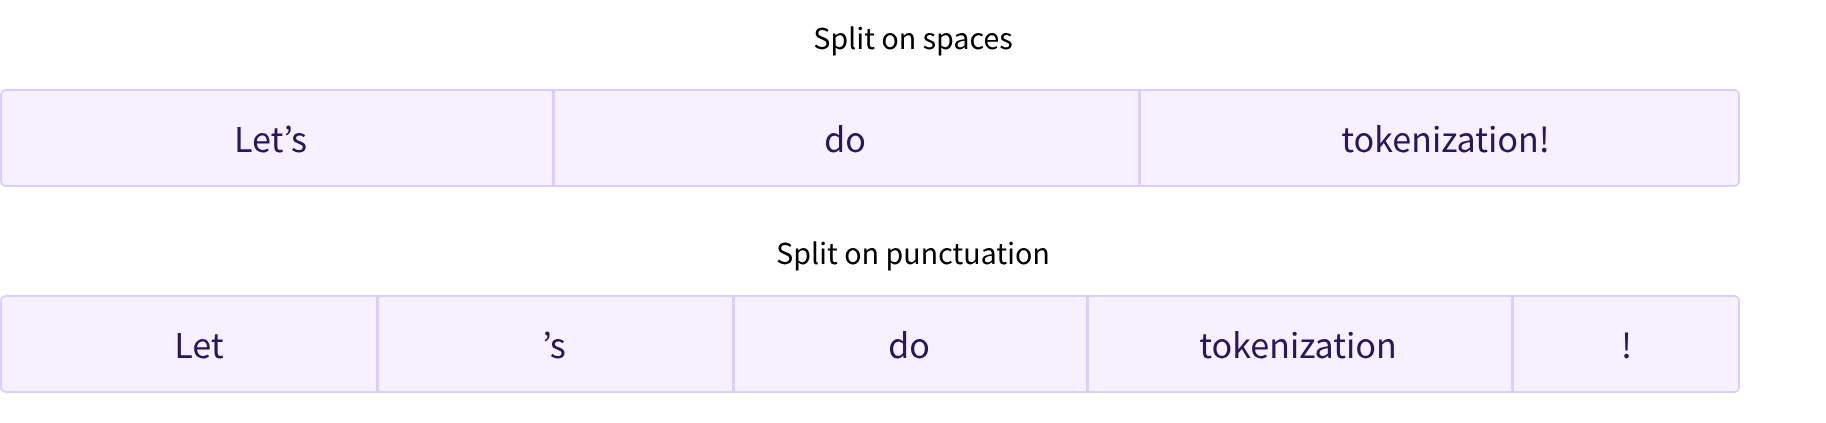

ada 2 pendekatan bisa dengan berdasrkan spasi, bisa juga berdasarkan simbol/tanda baca.


In [32]:
#conton berdasarkan spasi
tokenized_text = "Jim Henson was a puppeteer".split()
print(tokenized_text)

['Jim', 'Henson', 'was', 'a', 'puppeteer']


Jika tokenisasi berdasarkan kata, akan diperlukan ID token dalam jumlah yang sangat besar. Jumlah kata dalam bahasa inggris ada sebanyak 500.000 maka diperlukan token sebanyak 500.000 untuk bisa mengcover seluruh kata yang ada dalam bahasa inggris.

Kata yang sebenarnya mirip seperti run dan running, dog dengan dogs akan memiliki makna yang berbeda karena model hanya mengenali kata dog bukan dogs meskipun merek berdua mirip.

Diperlukan juga token khusus untuk merepresentasikan kata yang tidak ada dalam vocabulary biasanya dinamakan sebagai unknown. Jika tokenizer seringkali tidak menghasilkan token unknown artinya model tidak bisa menerima representasi yang masuk akal dari sebuah kata dan kehilangan informasi.

## 4.2 Character Based

---
1. character based melakukan tokenizer dengan cara membagi teks menjadi karakter atau huruf. cara ini punya 2 kelebihan:
  1. Vocabulary akan menjadi lebih kecil
  2. jumlah token unknown akan mejadi jauh lebih sedikti, karena setiap kata dapat dibentuk dari huruf.
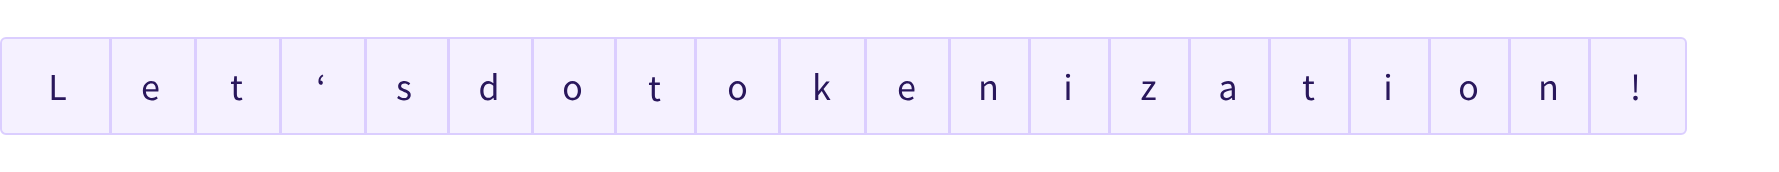

Tapi, karena sekarang represetasinya berdasarkan sebuah huruf maka menjadi kurang bermakna karena tiap huruf tidak bermakna banyak berbeda dengan sebuah kata. Selain itu dengan tokenisasi tiap huruf model perlu untuk memproses jumlah token yang sangat banyak berbeda dengan ketika tokennya berupa kata.

## 4.3 Subword Based

---
Subword menggunakan prinsip **kata yang sering muncul tidak perlu dipecah menjadi subkata, namun kata yang jarang digunakan dipecah menjadi subkata yang lebih bermakna**

Contohnya: annoyingly adalah kata yang jarang dan bisa dipisah menjadi annoying dan ly. kedua kata tersebut lebih sering muncul dan arti kata dari annoyingly masih bisa dicari dengan menggabungkan kata annyoing dan ly.
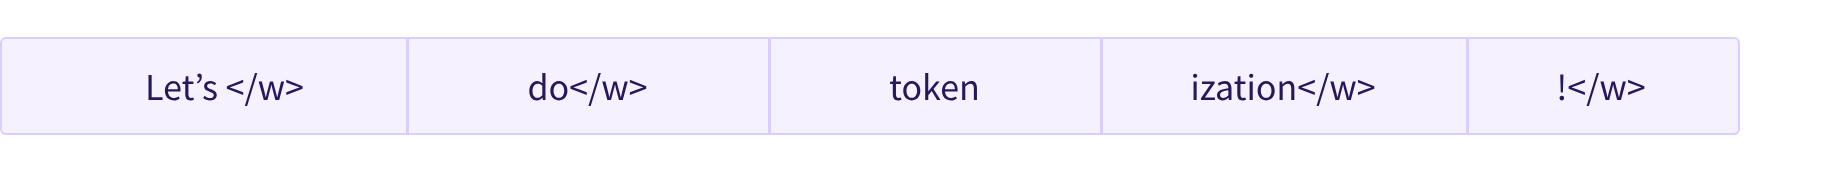

Masih banyak cara lain yang untuk melakukan tokenisasi


*   Byte-level BPE, as used in GPT-2
*   WordPiece, as used in BERT
*   SentencePiece or Unigram, as used in several multilingual models





## 4.4 Load And Save Tokenizer

In [33]:
# buat load dan save tokenizer sama seperti sebelumnya menggunakan from_pretrained() dan save_pretrained()

# ganti **Model dengan **TOkenizer buat load TOkenizer model tersebut

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

3 #bisa juga dengan menggunakan AutoTokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [34]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [35]:
#saving tokenizer
tokenizer.save_pretrained("directory_on_my_computer")

('directory_on_my_computer/tokenizer_config.json',
 'directory_on_my_computer/special_tokens_map.json',
 'directory_on_my_computer/vocab.txt',
 'directory_on_my_computer/added_tokens.json',
 'directory_on_my_computer/tokenizer.json')

## 4.5 Encoding

---
1. Mengubah teks menjadi sebuha bilangan.
2. ada 2 step-> tokenisasi sama konversi ke input ID
3. Step 1, adalah memecah teks menjadi kata (atau subkata, atau tanda baca, dll) yang disebut dengan token.
4. ada banyak cara untuk melakukan tokeninsasi oleh karena itu diperlukan inisialisasi Tokenizer yang sesuai dengan model yang dipretrained.
5. konversi token ke input ID, sehingga bisa diubah menjadi tensor dan dimasukan ke dalam model.

In [36]:
from transformers import AutoTokenizer

#gunakan tokenisasi yang sama dengan best-base-cased
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

#tokeninsasi sequence
sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


In [38]:
#convert jadi input ID
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[7993, 170, 13809, 23763, 2443, 1110, 3014]


## 4.6 Decoding

---
1. kebalikannya proses mengubah input ID menjadi kata

In [39]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

Using a transformer network is simple


# 5. Handling multiple sequences


## 5.1 Model menerima input dalam bentuk batch

In [49]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# menentukan model mana yang mau dipakai
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

#ambil tokenizer model tersebut
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

#ambil bobot model tersebut
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

#kalimatnya
sequence = "I've been waiting for a HuggingFace course my whole life."

#tokenisasi
tokens = tokenizer.tokenize(sequence)

#konversi ke id
ids = tokenizer.convert_tokens_to_ids(tokens)

#ubah ke tensor
#input_ids = torch.tensor(ids) #belum dalam bentuk batch masih 1 dimensi ([14])
input_ids = torch.tensor([ids]) #ini yang benar udah dalam bentuk batch ([1,14])

outputs = model(input_ids)

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[0.0037, 0.9963]], grad_fn=<SoftmaxBackward0>)


## 5.2 Pad Input

---
1. kalau misalnya ada teks yang berbeda panjangnya perlu dikasih pad biar panjang kalimatnya sama.
2. untuk nambahin pad bisa pad_token_id ditambah dengan attention_mask.
3. Attention mask adalah tensor yang punya bentuk sama dengan input ID tensor, bedanya diisi dengan 0 dan 1: 1 artinya model perlu memperhatikan kata tersebut sementara 0 artinya masking kata tersebut atau tidak perlu perhatikan kata tersebut.

In [51]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[0.9507, 0.0493],
        [0.7297, 0.2703]], grad_fn=<SoftmaxBackward0>)


## 5.3 Sekuens yang terlalu panjang

---
1. model transformers memiliki batas panjang teks atau sekuens yang bisa masuk ke dalam model. Umumnya 512 atau 1024.
2. ada 2 solusi untuk teks yang terlalu panjang,
  * bisa dengan memotong teks tersebut hingga nilai maksimal yang bisa masuk ke dalam model
  * bisa juga dengan menggunakan model lain yang bisa menerima input yang lebih panjang

# 6. Putting it All Together

In [62]:
#import package
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#pilih model card
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

#Ambil tokenizer dari model tersebut
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

#teksnya
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

#Encoding
#tokenizer(kata, padding = ..., max_length = ..., truncation = ..., return_tensors = ....)
tokenisasi = tokenizer(sequences, padding = "longest", truncation = True, return_tensors ='pt')

  # pad ke maksimum sekuens -> padding = "longest"
  # pad ke maksimum sekuens dari model (mis. BERT 512 maka jadi dipad menjadi 512) -> padding = "max_longest"
  # pad ke panjang tertentu -> padding = "max_length", max_length = (mis 8)
  # potong kalimat yang lebih panjang dari maksimal model (BERT 512) -> truncation = True
  # potong kalimat yang lebih panjang dari ketentuan -> truncation = True, max_length = (mis 8)
  # return_tensors = bentuk return dari tensornya bisa pytorch, TF, numpy, JAX

    #Kalau terpisah juga bisa -> Tokenisasi
    # tokenisasi = tokenizer.tokenize(sequence)
    # print("hasil tokenisasi = ", tokenisasi)

    #Kalau terpisah juga bisa -> Konversi ke ID
    # ids = tokenizer.convert_tokens_to_ids(tokenisasi)
    # print("Konversi ID = ", ids)

print(tokenisasi)

# load model dan set jadi sentiment analysis
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**tokenisasi)

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  2061,  2031,  1045,   999,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}
tensor([[4.0195e-02, 9.5980e-01],
        [5.3534e-04, 9.9946e-01]], grad_fn=<SoftmaxBackward0>)


# 7. Basic Usage Completed

# 8. Quiz